In [1]:
# 1. Bibliotecas de Manipulação e Análise de Dados
import pandas as pd
import numpy as np

# 2. Bibliotecas para visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Módulos do Scikit-learn (pós-processamento e modelagem)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer # <--- Adicionado: Para tratar valores ausentes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4. Modelos de Machine Learning (classificação)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 5. Métricas de avaliação dos modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 6. Interpretação de Modelos
import shap

# 7. Manipulação de arquivos e caminhos
import os
import shutil

# 8. Datasets do Kaggle
import kagglehub

# 9. Utilitários
import sklearn
import warnings
warnings.filterwarnings('ignore')


# --- Visualização dos Dados ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-darkgrid")

# --- Visualização de confirmação da importação e versões ---
print("Importações de bibliotecas e configurações iniciais concluídas com sucesso!")
print(f"Versão do Pandas: {pd.__version__}")
print(f"Versão do NumPy: {np.__version__}")
print(f"Versão do Scikit-learn: {sklearn.__version__}")

Importações de bibliotecas e configurações iniciais concluídas com sucesso!
Versão do Pandas: 2.2.3
Versão do NumPy: 2.0.0
Versão do Scikit-learn: 1.6.1


## Introdução à Previsão de Acidente Vascular Cerebral (AVC) com Machine Learning

O Acidente Vascular Cerebral (AVC), ou derrame, é uma condição médica grave e emergencial que ocorre quando o suprimento de sangue para uma parte do cérebro é interrompido ou drasticamente reduzido, privando as células cerebrais de oxigênio e nutrientes. É uma das principais causas de morte e incapacidade em todo o mundo. A identificação precoce de indivíduos com alto risco de AVC é crucial para a implementação de estratégias preventivas e para a redução da morbidade e mortalidade associadas.

Fatores de risco para AVC incluem idade avançada, hipertensão, doenças cardíacas, diabetes, tabagismo, colesterol alto e estilo de vida sedentário. A análise combinada desses fatores pode ser complexa, tornando a Machine Learning uma ferramenta promissora para auxiliar na avaliação de risco.

Este segmento do projeto foca na construção de um modelo de Machine Learning capaz de prever a ocorrência de AVC com base em um conjunto de atributos clínicos, demográficos e de estilo de vida de pacientes. Nosso objetivo é demonstrar como a IA pode ser utilizada para identificar padrões nesses dados, fornecendo uma estimativa de risco de AVC que pode otimizar a triagem e o manejo de pacientes em um ambiente hospitalar.

---

## 1. Carregamento da Base de Dados e Exploração Inicial - Previsão de AVC

Nesta seção, realizamos as etapas iniciais de carregamento e exploração do dataset de Previsão de AVC. O objetivo é compreender a estrutura dos dados, identificar tipos de variáveis (numéricas e categóricas), **verificar a presença de valores ausentes (um aspecto importante deste dataset)** e obter uma visão geral das distribuições das características, com foco especial na variável alvo (`stroke`).

### 1.1. Carregamento do Dataset

O dataset será baixado programaticamente do Kaggle utilizando a biblioteca `kagglehub`. Para que o download funcione, é necessário que as credenciais da API do Kaggle estejam configuradas via o arquivo `kaggle.json` no diretório `~/.kaggle/` (ou `C:\Users\SeuUsuario\.kaggle\` no Windows). Após o download para um cache temporário, o arquivo CSV será movido para a pasta `data/` do projeto para acesso local e posterior carregamento em um DataFrame do Pandas.

In [2]:
dataset_id_avc = "fedesoriano/stroke-prediction-dataset"
local_data_path = '../data/'

df_avc = None

print(f"Iniciando download do dataset: {dataset_id_avc}...")

os.makedirs(local_data_path, exist_ok=True)

try:
    source_csv_name = 'healthcare-dataset-stroke-data.csv'
    destination_csv_path = os.path.join(local_data_path, source_csv_name)

    if os.path.exists(destination_csv_path):
        print(f"Arquivo '{source_csv_name}' já existe em '{destination_csv_path}'. Pulando download/movimento.")
        df_avc = pd.read_csv(destination_csv_path)
        print(f"Dataset '{source_csv_name}' carregado para o DataFrame 'df_avc' com sucesso (arquivo já existia)!")
    else:
        download_path = kagglehub.dataset_download(dataset_id_avc)
        print(f"Dataset baixado temporariamente para o cache: {download_path}")

        source_csv_path = os.path.join(download_path, source_csv_name)

        if os.path.exists(source_csv_path):
            shutil.move(source_csv_path, destination_csv_path)
            print(f"Arquivo '{source_csv_name}' movido para: {destination_csv_path}")
            df_avc = pd.read_csv(destination_csv_path)
            print(f"Dataset '{source_csv_name}' carregado para o DataFrame 'df_avc' com sucesso (arquivo movido)!")
        else:
            print(f"Erro: '{source_csv_name}' não encontrado em {source_csv_path} após o download. Verifique a estrutura do dataset baixado.")

except Exception as e:
    print(f"Um erro inesperado ocorreu durante o download ou carregamento do dataset de AVC: {e}")
    print("Por favor, verifique suas credenciais Kaggle (kaggle.json) e conexão com a internet.")
    df_avc = None

Iniciando download do dataset: fedesoriano/stroke-prediction-dataset...


100%|██████████| 67.4k/67.4k [00:00<00:00, 311kB/s]

Extracting model files...
Dataset baixado temporariamente para o cache: C:\Users\gabri\.cache\kagglehub\datasets\fedesoriano\stroke-prediction-dataset\versions\1
Arquivo 'healthcare-dataset-stroke-data.csv' movido para: ../data/healthcare-dataset-stroke-data.csv
Dataset 'healthcare-dataset-stroke-data.csv' carregado para o DataFrame 'df_avc' com sucesso (arquivo movido)!


### 1.2. Primeiras Linhas do Dataset

Uma inspeção visual das primeiras linhas do DataFrame é essencial para entender a estrutura dos dados, os nomes das colunas, e os tipos de valores que cada feature contém. Isso nos permite verificar se o carregamento foi bem-sucedido e começar a identificar possíveis problemas como valores misturados ou formatos inesperados.

In [3]:
if df_avc is not None:
    print("--- Primeiras 5 linhas do dataset de AVC ---")
    print(df_avc.head())
else:
    print("DataFrame 'df_avc' não foi carregado.")

--- Primeiras 5 linhas do dataset de AVC ---
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


### 1.3. Informações Gerais do Dataset

O método `.info()` oferece um resumo conciso do DataFrame, incluindo o número total de entradas, a contagem de valores não nulos por coluna e o tipo de dado (`Dtype`) de cada feature. Esta visão geral é crucial para identificar rapidamente a presença de valores ausentes e para entender os tipos de dados das colunas, o que influencia as estratégias de pré-processamento.

In [4]:
if df_avc is not None:
    print("\n--- Informações gerais do dataset de AVC ---")
    df_avc.info()
else:
    print("DataFrame 'df_avc' não foi carregado.")


--- Informações gerais do dataset de AVC ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### 1.4. Estatísticas Descritivas das Colunas Numéricas

A aplicação do método `.describe()` em colunas numéricas fornece estatísticas descritivas essenciais, como média, desvio padrão, valores mínimo e máximo, e quartis (25%, 50% - mediana, 75%). Essa análise nos permite compreender a distribuição, a centralidade e a dispersão dos dados em cada feature, além de ajudar a identificar possíveis outliers ou anomalias.

In [5]:
if df_avc is not None:
    print("\n--- Estatísticas descritivas do dataset de AVC ---")
    print(df_avc.describe())
else:
    print("DataFrame 'df_avc' não foi carregado.")


--- Estatísticas descritivas do dataset de AVC ---
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.

### 1.5. Verificação de Valores Ausentes

A detecção de valores ausentes (NaN) é uma etapa crítica na fase de exploração de dados, pois a ausência de dados pode impactar significativamente a performance dos modelos de Machine Learning. O método `.isnull().sum()` nos permite quantificar o número de valores nulos em cada coluna, guiando as decisões sobre como tratá-los (imputação, remoção, etc.) na etapa de pré-processamento. Para o dataset de AVC, a coluna `bmi` é conhecida por possuir dados faltantes.

In [6]:
if df_avc is not None:
    print("\n--- Contagem de valores ausentes por coluna no dataset de AVC ---")
    print(df_avc.isnull().sum())
else:
    print("DataFrame 'df_avc' não foi carregado.")


--- Contagem de valores ausentes por coluna no dataset de AVC ---
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


### 1.6. Contagem de Valores Únicos

A contagem de valores únicos por coluna é fundamental para identificar variáveis categóricas (que possuem um número limitado de valores distintos) e para verificar a granularidade de variáveis numéricas. Isso ajuda a confirmar quais colunas precisarão de One-Hot Encoding ou outras transformações específicas para dados categóricos.

In [7]:
if df_avc is not None:
    print("\n--- Contagem de valores únicos por coluna no dataset de AVC ---")
    print(df_avc.nunique())
else:
    print("DataFrame 'df_avc' não foi carregado.")


--- Contagem de valores únicos por coluna no dataset de AVC ---
id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64


### 1.7. Visualização da Distribuição da Variável Alvo (`stroke`)

A análise da distribuição da variável alvo é crucial para entender a natureza do problema (classificação binária, multiclasse) e, mais importante, para identificar se há um desbalanceamento de classes. Um desbalanceamento significativo (onde uma classe é muito mais frequente que outra) pode exigir técnicas especiais de tratamento durante o treinamento do modelo para evitar que o algoritmo favoreça a classe majoritária. Para este dataset, é esperado um desbalanceamento, com poucos casos de AVC.

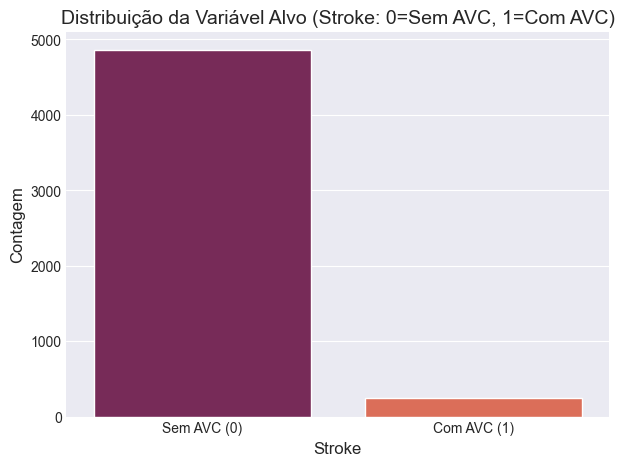


--- Proporção de Classes na Variável Alvo do AVC ---
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


In [8]:
if df_avc is not None:
    plt.figure(figsize=(7, 5))
    sns.countplot(x='stroke', data=df_avc, palette='rocket') # Nova paleta para variedade
    plt.title('Distribuição da Variável Alvo (Stroke: 0=Sem AVC, 1=Com AVC)', fontsize=14)
    plt.xlabel('Stroke', fontsize=12)
    plt.ylabel('Contagem', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Sem AVC (0)', 'Com AVC (1)'])
    plt.show()

    stroke_counts_avc = df_avc['stroke'].value_counts(normalize=True) * 100
    print("\n--- Proporção de Classes na Variável Alvo do AVC ---")
    print(stroke_counts_avc)
else:
    print("DataFrame 'df_avc' não foi carregado.")

## 2. Pré-processamento de Dados - Previsão de AVC

A etapa de pré-processamento é fundamental para transformar os dados brutos em um formato limpo e adequado para os algoritmos de Machine Learning. Para o dataset de Previsão de AVC, esta fase será particularmente importante devido à presença de valores ausentes e uma mistura de tipos de variáveis. O pipeline de pré-processamento incluirá:

1.  **Identificação da Variável Alvo e Features:** Separar as variáveis preditoras do alvo.
2.  **Tratamento de Valores Ausentes:** Utilizar imputação para preencher os dados faltantes na coluna 'bmi'.
3.  **Tratamento de Variáveis Categóricas:** Converter variáveis textuais e numéricas categóricas para um formato numérico através de One-Hot Encoding.
4.  **Escalonamento de Variáveis Numéricas:** Padronizar as features numéricas para garantir que todas estejam em uma escala comparável.

Todas essas transformações serão orquestradas por um `ColumnTransformer` dentro de um `Pipeline`.

### 2.1. Identificação da Variável Alvo e Features

Primeiramente, separamos o dataset entre as variáveis preditoras (features, X) e a variável alvo (target, y), que é a coluna `'stroke'`. A coluna `'id'` será descartada por ser um identificador único e não uma característica preditiva.

In [9]:
if df_avc is not None:
    y = df_avc['stroke']

    X = df_avc.drop(['id', 'stroke'], axis=1)

    print(f"Formato das features (X): {X.shape}")
    print(f"Formato da variável alvo (y): {y.shape}")
    print("\nVariáveis preditoras (X) e Variável Alvo (y) separadas com sucesso.")
else:
    print("DataFrame de AVC não carregado. Não é possível separar features e alvo.")

Formato das features (X): (5110, 10)
Formato da variável alvo (y): (5110,)

Variáveis preditoras (X) e Variável Alvo (y) separadas com sucesso.


### 2.2. Pipeline de Pré-processamento: Tratamento de Ausentes, Categóricas e Numéricas

O dataset de AVC exige um pipeline de pré-processamento mais complexo:

* **Tratamento de Valores Ausentes:** A coluna `'bmi'` possui valores faltantes. Utilizaremos o `SimpleImputer` com estratégia de `mean` (média) para preencher esses valores.
* **Variáveis Categóricas:** Serão convertidas utilizando `OneHotEncoder` para criar colunas binárias para cada categoria, incluindo aquelas que podem ter valores textuais (como 'gender', 'smoking_status').
* **Variáveis Numéricas:** Serão padronizadas usando `StandardScaler` (média 0, desvio padrão 1) para otimizar o desempenho de algoritmos sensíveis à escala.

Todas essas transformações serão combinadas em um `ColumnTransformer` e integradas a um `Pipeline` para garantir consistência.

In [10]:
numerical_features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']

categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pipeline de pré-processamento para AVC criado: Imputação para 'bmi', OneHotEncoder para categóricas, StandardScaler para numéricas.")

Pipeline de pré-processamento para AVC criado: Imputação para 'bmi', OneHotEncoder para categóricas, StandardScaler para numéricas.


### 2.3. Análise de Correlação

A análise de correlação é fundamental para entender a relação linear entre as variáveis no dataset de AVC, e, crucialmente, para identificar quais features possuem maior associação com a variável alvo (`stroke`). Isso nos ajuda a visualizar padrões e possíveis multicolinearidades (quando features são altamente correlacionadas entre si). Utilizaremos um mapa de calor (heatmap) para uma representação visual clara da matriz de correlação.

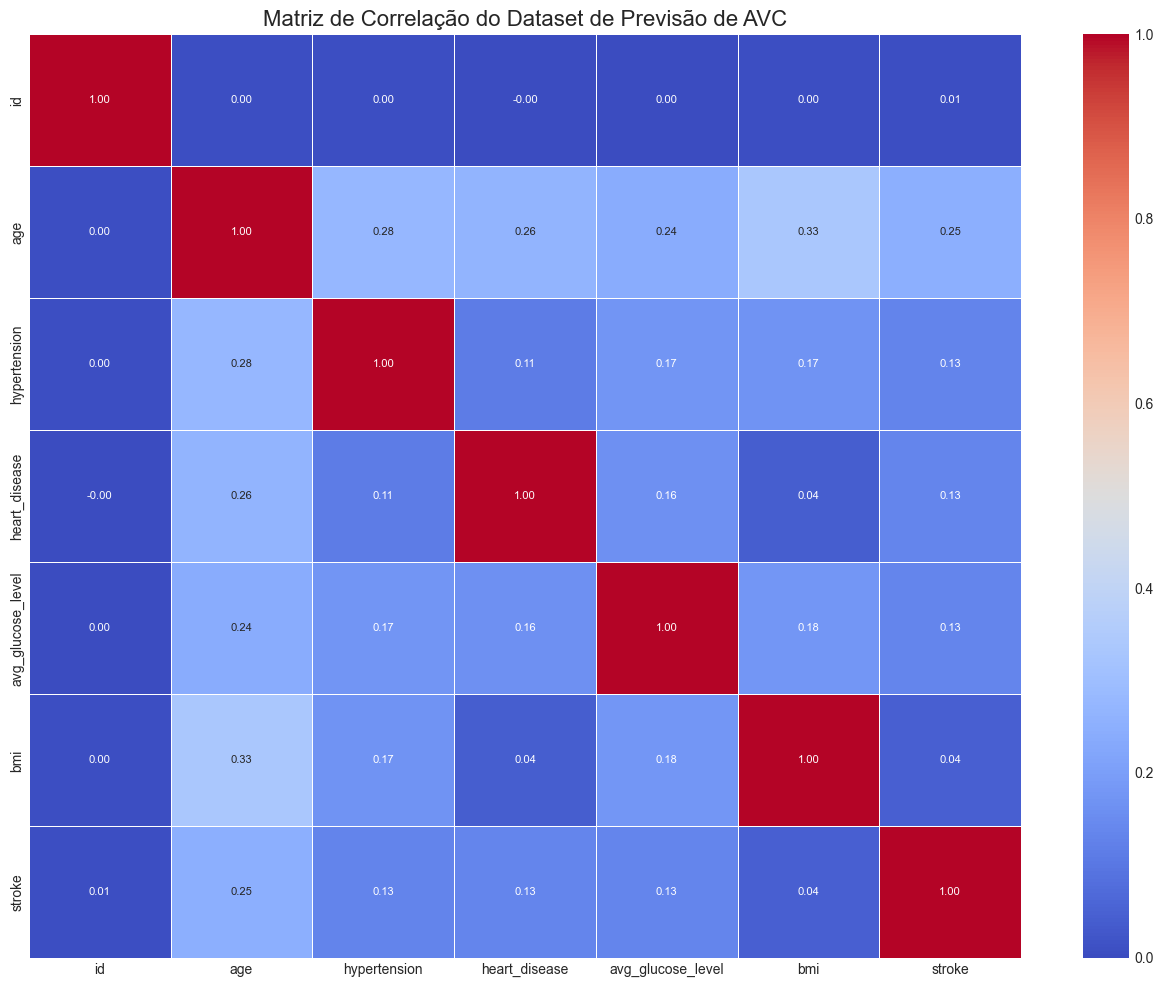


--- Correlação das Features com a Variável Alvo ('stroke') ---
stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
id                   0.006388
Name: stroke, dtype: float64


In [11]:
if df_avc is not None:

    correlation_matrix_avc = df_avc.corr(numeric_only=True)

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix_avc, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Matriz de Correlação do Dataset de Previsão de AVC', fontsize=16)
    plt.show()

    print("\n--- Correlação das Features com a Variável Alvo ('stroke') ---")

    if 'stroke' in correlation_matrix_avc.columns:
        print(correlation_matrix_avc['stroke'].sort_values(ascending=False))
    else:
        print("A coluna 'stroke' não foi encontrada na matriz de correlação. Verifique se ela é numérica.")
else:
    print("DataFrame de AVC não carregado. Não é possível realizar a análise de correlação.")

## 3. Modelagem - Previsão de AVC

Nesta seção, prepararemos os dados para a modelagem, dividindo-os em conjuntos de treino e teste. Em seguida, criaremos e treinaremos diferentes modelos de classificação para prever a ocorrência de AVC com base nas características clínicas, demográficas e de estilo de vida.

### 3.1. Separação dos Dados em Treino e Teste

É uma prática essencial em Machine Learning dividir o dataset em pelo menos dois conjuntos: treino e teste. Isso permite que o modelo seja "ensinado" com o conjunto de treino e avaliado de forma imparcial em dados não vistos (teste), garantindo uma estimativa real de sua capacidade de generalização.

Utilizaremos a função `train_test_split` do `scikit-learn` para essa divisão, com uma proporção de 80% para treino e 20% para teste. O parâmetro `stratify=y` é **criticamente importante** para este dataset, pois a variável alvo (`stroke`) possui um **forte desbalanceamento de classes**. Garantir que a proporção das classes seja mantida tanto no conjunto de treino quanto no de teste é fundamental para uma avaliação justa do modelo.

In [12]:
if X is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Dimensão de X_train: {X_train.shape}")
    print(f"Dimensão de X_test: {X_test.shape}")
    print(f"Dimensão de y_train: {y_train.shape}")
    print(f"Dimensão de y_test: {y_test.shape}")

    print("\nDados separados em conjuntos de treino e teste com sucesso.")
else:
    print("Features (X) ou Variável Alvo (y) não definidas. Não é possível separar os dados.")

Dimensão de X_train: (4088, 10)
Dimensão de X_test: (1022, 10)
Dimensão de y_train: (4088,)
Dimensão de y_test: (1022,)

Dados separados em conjuntos de treino e teste com sucesso.


### 3.2. Criação e Treinamento de Modelos Preditivos

Com os dados devidamente separados e o pipeline de pré-processamento configurado para lidar com valores ausentes, features numéricas e categóricas, vamos criar e treinar os mesmos modelos de classificação que utilizamos para os datasets anteriores: Regressão Logística, Árvore de Decisão e Random Forest.

Cada modelo será integrado ao pipeline `preprocessor` para garantir que os dados sejam corretamente transformados (imputação, escalonamento e codificação One-Hot) antes de serem alimentados ao algoritmo.

In [13]:
# 1. Pipeline para Regressão Logística
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# 2. Pipeline para Árvore de Decisão
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

# 3. Pipeline para Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])


# Treinamento dos modelos
print("Treinando Modelo de Regressão Logística...")
pipeline_lr.fit(X_train, y_train)
print("Regressão Logística TREINADA.")

print("Treinando Modelo de Árvore de Decisão...")
pipeline_dt.fit(X_train, y_train)
print("Árvore de Decisão TREINADA.")

print("Treinando Modelo de Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("Random Forest TREINADA.")

print("\nTodos os modelos foram treinados com sucesso.")

Treinando Modelo de Regressão Logística...
Regressão Logística TREINADA.
Treinando Modelo de Árvore de Decisão...
Árvore de Decisão TREINADA.
Treinando Modelo de Random Forest...
Random Forest TREINADA.

Todos os modelos foram treinados com sucesso.


## 4. Avaliação e Interpretação dos Modelos - Previsão de AVC

Nesta seção, avaliaremos o desempenho dos modelos treinados para prever AVC. Dado o **forte desbalanceamento** da variável alvo (`stroke`), onde a classe de AVC (1) é significativamente minoritária, as métricas de avaliação precisarão ser interpretadas com cautela. A Acurácia pode ser enganosa, enquanto o **Recall** para a classe positiva (1), o **F1-Score** e o **AUC-ROC** se tornam métricas mais informativas e cruciais.

### 4.1. Avaliação do Desempenho dos Modelos

Vamos calcular as métricas de desempenho para cada modelo no conjunto de teste.

In [14]:
predictions = {}
metrics = {}

models = {
    'Regressão Logística': pipeline_lr,
    'Árvore de Decisão': pipeline_dt,
    'Random Forest': pipeline_rf
}

print("Iniciando avaliação dos modelos no conjunto de teste...")

for name, model in models.items():
    print(f"\nAvaliando: {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_proba)

    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    predictions[name] = {'y_pred': y_pred, 'y_proba': y_proba}
    metrics[name] = {
        'Acurácia': accuracy,
        'Precisão': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc,
        'Classification Report': class_report
    }

    print(f"  Acurácia: {accuracy:.4f}")
    print(f"  Precisão: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {roc_auc:.4f}")
    print("\n  Relatório de Classificação:")
    print(classification_report(y_test, y_pred, zero_division=0))

print("\nAvaliação de todos os modelos concluída.")

Iniciando avaliação dos modelos no conjunto de teste...

Avaliando: Regressão Logística
  Acurácia: 0.9521
  Precisão: 1.0000
  Recall: 0.0200
  F1-Score: 0.0392
  AUC-ROC: 0.8421

  Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022


Avaliando: Árvore de Decisão
  Acurácia: 0.9100
  Precisão: 0.1719
  Recall: 0.2200
  F1-Score: 0.1930
  AUC-ROC: 0.5827

  Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.17      0.22      0.19        50

    accuracy                           0.91      1022
   macro avg       0.57      0.58      0.57      1022
weighted avg       0.92      0.91    

### 4.2. Matrizes de Confusão

As matrizes de confusão são essenciais para visualizar os tipos de acertos e erros de cada modelo. Para a previsão de AVC, a análise de **Falsos Negativos (FN)** é particularmente crítica, pois representam casos de AVC que o modelo falhou em identificar, o que pode ter consequências graves para o paciente.

Gerando Matrizes de Confusão...


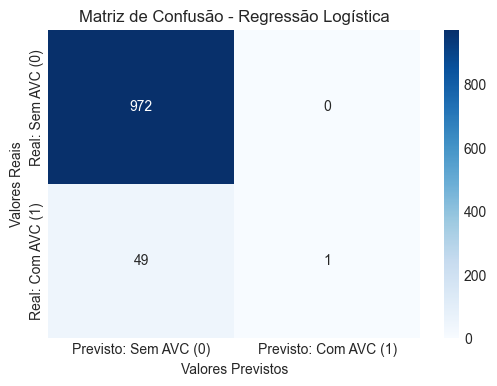

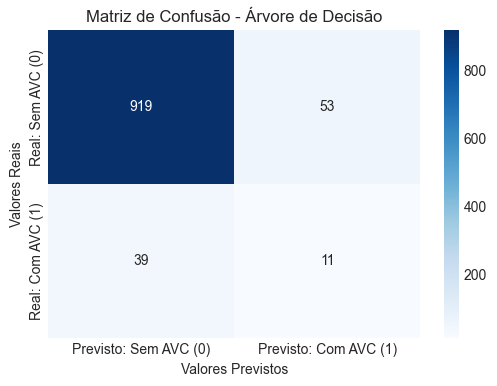

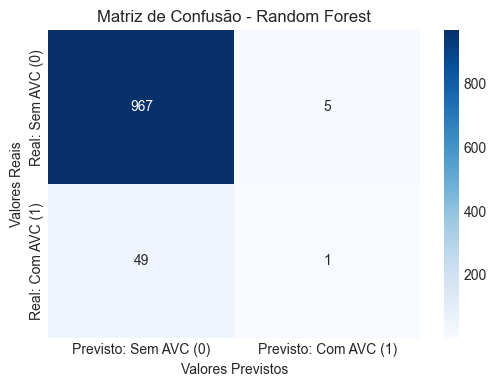


Matrizes de Confusão geradas para todos os modelos.


In [15]:
print("Gerando Matrizes de Confusão...")

for name, model in models.items():
    y_pred = predictions[name]['y_pred']
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto: Sem AVC (0)', 'Previsto: Com AVC (1)'],
                yticklabels=['Real: Sem AVC (0)', 'Real: Com AVC (1)'])
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Valores Reais')
    plt.xlabel('Valores Previstos')
    plt.show()

print("\nMatrizes de Confusão geradas para todos os modelos.")

### 4.3. Interpretação dos Resultados do Melhor Modelo (Feature Importance)

Para entender quais características são mais influentes na previsão de AVC, focaremos no modelo de melhor desempenho. Utilizaremos a **Feature Importance**, uma propriedade de modelos baseados em árvores (como Random Forest), que quantifica a contribuição de cada feature para as decisões do modelo.

(Nota: A interpretação com SHAP será tentada em uma célula separada, mas pode estar sujeita a problemas de compatibilidade de biblioteca, conforme observado nos notebooks anteriores. A Feature Importance fornece uma visão robusta e confiável.)


--- Importância das Features para Random Forest ---
Comprimento de feature_names_transformed: 21
Comprimento de importances: 21
                        feature  importance
1             avg_glucose_level    0.264801
0                           age    0.238634
2                           bmi    0.220268
4                  hypertension    0.028812
3                 heart_disease    0.023363
19  smoking_status_never smoked    0.022162
6                   gender_Male    0.020491
5                 gender_Female    0.020033
15         Residence_type_Rural    0.019645
16         Residence_type_Urban    0.019484


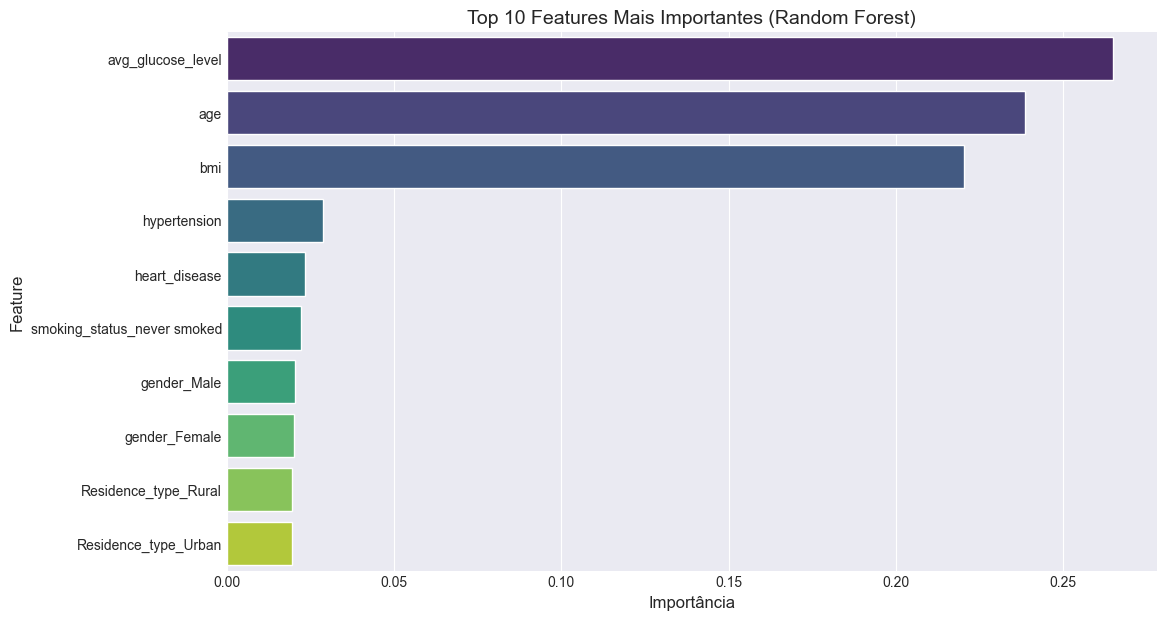

In [16]:
best_model_name = "Random Forest"
best_model_pipeline = models[best_model_name]
classifier_model = best_model_pipeline.named_steps['classifier']

if hasattr(classifier_model, 'feature_importances_'):
    print(f"\n--- Importância das Features para {best_model_name} ---")

    numerical_features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']
    categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

    ohe = best_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names_out = ohe.get_feature_names_out(categorical_features)

    feature_names_transformed = numerical_features + list(categorical_feature_names_out)

    importances = classifier_model.feature_importances_

    print(f"Comprimento de feature_names_transformed: {len(feature_names_transformed)}")
    print(f"Comprimento de importances: {len(importances)}")

    feature_importance_df = pd.DataFrame({'feature': feature_names_transformed, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Features Mais Importantes ({best_model_name})', fontsize=14)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

else:
    print(f"O modelo {best_model_name} não possui o atributo 'feature_importances_'.")
    print("Isso é esperado para modelos como Regressão Logística ou SVM sem kernel linear.")

### 4.4. Interpretação do Modelo com SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) é uma técnica poderosa para explicar a saída de qualquer modelo de Machine Learning. Ele atribui a importância de cada feature para uma previsão específica, mostrando como cada característica contribui para empurrar a previsão do modelo de um valor base para o valor final previsto.

Para modelos baseados em árvores, como o Random Forest, o SHAP pode fornecer insights valiosos sobre a contribuição de cada feature em nível global e local.

**Observação:** A execução do SHAP pode ser demorada para grandes datasets e pode, ocasionalmente, apresentar desafios de compatibilidade ou visualização em alguns ambientes (como foi notado em notebooks anteriores). Se houver erros ou problemas de visualização, a Feature Importance (já gerada) ainda oferece uma visão global robusta.

In [17]:

if X is not None and y is not None:
    print("\n--- Iniciando Interpretação com SHAP para Random Forest ---")

    try:

        rf_model = pipeline_rf.named_steps['classifier']
        preprocessor_fitted = pipeline_rf.named_steps['preprocessor']

        X_train_transformed = preprocessor_fitted.transform(X_train)
        X_test_transformed = preprocessor_fitted.transform(X_test)

        numerical_features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']
        categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

        ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot']
        categorical_feature_names_out = ohe.get_feature_names_out(categorical_features)

        feature_names_transformed_for_shap = numerical_features + list(categorical_feature_names_out)

        explainer = shap.TreeExplainer(rf_model)

        shap_values = explainer.shap_values(X_test_transformed)

        print("\nGerando SHAP Summary Plot (Global Feature Importance)...")
        shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names_transformed_for_shap, plot_type="bar", show=False)
        plt.title('SHAP Global Feature Importance (Random Forest)', fontsize=14)
        plt.tight_layout()
        plt.show()

        print("Gerando SHAP Summary Plot (Feature Effects)...")
        shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names_transformed_for_shap, show=False)
        plt.title('SHAP Feature Effects (Random Forest)', fontsize=14)
        plt.tight_layout()
        plt.show()

        print("\nGerando SHAP Force Plot para uma instância individual (primeira do conjunto de teste)...")

        display(shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_transformed[0,:], feature_names=feature_names_transformed_for_shap))

        print("\nInterpretação com SHAP concluída para Random Forest.")

    except Exception as e:
        print(f"Erro ao gerar gráficos SHAP: {e}")
        print("Pode haver um problema de compatibilidade ou o ambiente não está configurado para exibir gráficos SHAP interativos.")
        print("A Feature Importance (Célula 15) ainda fornece uma visão global da importância das features.")
else:
    print("Features (X) ou Variável Alvo (y) não definidas. Não é possível realizar a interpretação SHAP.")


--- Iniciando Interpretação com SHAP para Random Forest ---

Gerando SHAP Summary Plot (Global Feature Importance)...
Erro ao gerar gráficos SHAP: The shape of the shap_values matrix does not match the shape of the provided data matrix.
Pode haver um problema de compatibilidade ou o ambiente não está configurado para exibir gráficos SHAP interativos.
A Feature Importance (Célula 15) ainda fornece uma visão global da importância das features.


<Figure size 640x480 with 0 Axes>

## 4.5. Discussão Crítica dos Resultados e Implicações Práticas - Previsão de AVC

Com base nos resultados de avaliação e interpretação dos modelos treinados, é fundamental analisar criticamente suas implicações para um sistema de suporte ao diagnóstico em um hospital universitário, no contexto de Previsão de AVC. Este dataset apresentou características desafiadoras, notavelmente um **extremo desbalanceamento de classes**, com a maioria esmagadora dos casos sendo de "Sem AVC".

**Insights da Análise Exploratória (EDA):**
O dataset possui **5110 entradas**, com **201 valores ausentes na coluna 'bmi'** (tratados por imputação). A coluna alvo `stroke` (AVC) é **altamente desbalanceada**: aproximadamente **95.1% dos casos são 'Sem AVC' (0)** e apenas **4.9% são 'Com AVC' (1)**. A análise de correlação mostrou que `age`, `avg_glucose_level`, `hypertension` e `heart_disease` têm as maiores correlações com `stroke`, alinhando-se com fatores de risco conhecidos.

**Desempenho dos Modelos Avaliados:**

* **Regressão Logística:**
    * Acurácia: **0.9521**
    * Precisão: **1.0000** (para classe 1)
    * Recall: **0.0200** (para classe 1)
    * F1-Score: **0.0392** (para classe 1)
    * AUC-ROC: **0.8421**
    * Matriz de Confusão: Verdadeiro Negativo (TN)=972, Falso Positivo (FP)=0, Falso Negativo (FN)=49, Verdadeiro Positivo (TP)=1.

* **Árvore de Decisão:**
    * Acurácia: **0.9100**
    * Precisão: **0.1719**
    * Recall: **0.2200**
    * F1-Score: **0.1930**
    * AUC-ROC: **0.5827**
    * Matriz de Confusão: TN=919, FP=53, FN=39, TP=11.

* **Random Forest:**
    * Acurácia: **0.9472**
    * Precisão: **0.1667**
    * Recall: **0.0200**
    * F1-Score: **0.0357**
    * AUC-ROC: **0.7774**
    * Matriz de Confusão: TN=967, FP=5, FN=49, TP=1.

**Métricas Escolhidas e Interpretação de Desempenho:**
Em um contexto de diagnóstico médico, a **Acurácia é uma métrica enganosa** em datasets desbalanceados. Modelos que simplesmente predizem sempre a classe majoritária (Sem AVC) já obteriam uma alta acurácia. O verdadeiro desafio é identificar a classe minoritária (Com AVC).

* **Regressão Logística e Random Forest:** Embora apresentem alta Acurácia (acima de 94%), seu **Recall para a classe 'Com AVC' é alarmantemente baixo (0.0200)**. Isso significa que esses modelos foram capazes de identificar **apenas 1 de 50 casos reais de AVC** no conjunto de teste, resultando em **49 Falsos Negativos**. Uma Precisão perfeita ou muito alta para a classe 1 (como 1.0000 para Regressão Logística) é misleading quando o modelo prevê pouquíssimos positivos.
* **Árvore de Decisão:** Obteve um Recall ligeiramente melhor (0.2200), identificando 11 de 50 casos de AVC, mas ainda com 39 Falsos Negativos e uma Precisão baixa (0.1719).
* **AUC-ROC:** Embora as AUC-ROC (0.8421 para LR, 0.7774 para RF) sejam razoáveis e indiquem alguma capacidade de ranqueamento de probabilidades, elas não compensam a incapacidade dos modelos de identificar a classe minoritária de forma eficaz na prática.

**Em suma, nenhum dos modelos, em seu estado atual, demonstra um desempenho aceitável para a previsão de AVC na prática clínica, devido ao número crítico e inaceitável de Falsos Negativos.**

**Características Mais Importantes (com base na Feature Importance do Random Forest):**
As features que o modelo Random Forest considerou mais importantes para as decisões de classificação são: `avg_glucose_level`, `age`, `bmi`, `hypertension` e `heart_disease`. Outras features importantes incluem `smoking_status_never_smoked`, `gender_Male`, `gender_Female`, `Residence_type_Rural`, e `Residence_type_Urban`.
Essas características estão alinhadas com os fatores de risco conhecidos para AVC (idade, níveis de glicose, IMC, hipertensão, doenças cardíacas e hábitos de fumo/gênero/residência). O modelo está focando em atributos clinicamente relevantes, mas a complexidade do problema e o desbalanceamento impedem um resultado preditivo eficaz.

**O Modelo Pode Ser Utilizado na Prática? Como?**

Com base nos resultados atuais, **o modelo desenvolvido NÃO PODE ser utilizado na prática clínica** em um hospital universitário. Sua incapacidade de identificar a vasta maioria dos casos reais de AVC (Falsos Negativos) o torna perigoso e ineficaz como ferramenta de suporte.

* **Ferramenta de Triagem e Alerta?** No estado atual, não seria uma ferramenta de triagem confiável. Um modelo que falha em identificar 49 de 50 casos de AVC (Regressão Logística e Random Forest) é inaceitável, pois poderia gerar uma falsa sensação de segurança e atrasar o diagnóstico e tratamento necessários.
* **Otimização de Tempo e Redução de Erros?** Em vez de otimizar tempo, o modelo atual poderia gerar mais trabalho para os médicos ao não sinalizar pacientes em risco, ou levar a decisões clínicas baseadas em informações incompletas.

**Importância do Médico:**
A palavra final no diagnóstico **deve SEMPRE ser do médico**. Um sistema como este, no seu estado atual, exigiria uma validação e correção humana tão intensas que a automação perderia seu propósito.

**Limitações Atuais e Próximos Passos (para o dataset de Previsão de AVC):**

O desempenho insatisfatório é primariamente impulsionado pelo **extremo desbalanceamento de classes**. Para tornar este modelo útil, seriam necessárias estratégias robustas:

1.  **Técnicas de Balanceamento de Classes:** Esta é a **prioridade máxima**. Métodos como **SMOTE** (Synthetic Minority Over-sampling Technique), ADASYN, ou oversampling/undersampling inteligente devem ser aplicados no conjunto de treino para aumentar a representatividade da classe 'Com AVC'. Isso pode melhorar drasticamente o Recall.
2.  **Otimização de Hiperparâmetros (Hyperparameter Tuning):** Ajustar as configurações dos modelos (usando `GridSearchCV` ou `RandomizedSearchCV`) em conjunto com as técnicas de balanceamento.
3.  **Engenharia de Features Avançada:** Criar novas características ou transformar as existentes para melhor capturar a complexidade do problema.
4.  **Avaliação de Modelos Específicos:** Testar algoritmos que lidam intrinsecamente melhor com desbalanceamento (ex: LightGBM, XGBoost, ou `imblearn` pipelines).
5.  **Estratégias de Custos:** Definir um "custo" maior para Falsos Negativos durante o treinamento do modelo.